In [1]:
# dataframe and series 
import pandas as pd
import numpy as np

# sklearn imports for modeling part
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,balanced_accuracy_score
from sklearn.model_selection import train_test_split

from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.plotting import plot_decision_regions

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
# To plot
import matplotlib.pyplot as plt  
%matplotlib inline    
import matplotlib as mpl
import seaborn as sns

import nltk
from nltk.corpus import stopwords

In [45]:
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

In [2]:
pd.options.display.max_columns=100 # To see the hidden columns in dataframe

In [3]:
df = pd.read_csv('cleaned_data.csv', low_memory=False)

In [ ]:
# stop = set(stopwords.words("english"))

In [ ]:
# taking only words which are not stopwords
# df_pos_count['word_without_stop'] = df_pos_count['word'].apply(lambda x: ''.join([word for word in x.split() if word not in (stop)]))

In [4]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewText,summary,title,day,month,year,sentiment,review_clean
0,4,True,2014-07-03,A2LSKD2H9U8N0J,B000FA5KK0,{'Format:': ' Kindle Edition'},"pretty good story, a little exaggerated, but i...",pretty good story,NaN,3,7,2014,2,pretty good story a little exaggerated but i l...
1,5,True,2014-05-26,A2QP13XTJND1QS,B000FA5KK0,{'Format:': ' Kindle Edition'},"if you've read other max brand westerns, you k...",A very good book,NaN,26,5,2014,2,if youve read other max brand westerns you kno...
2,5,True,2016-09-16,A8WQ7MAG3HFOZ,B000FA5KK0,{'Format:': ' Kindle Edition'},"love max, always a fun twist",Five Stars,NaN,16,9,2016,2,love max always a fun twist
3,5,True,2016-03-03,A1E0MODSRYP7O,B000FA5KK0,{'Format:': ' Kindle Edition'},"as usual for him, a good book",a good,NaN,3,3,2016,2,as usual for him a good book
4,5,True,2015-09-10,AYUTCGVSM1H7T,B000FA5KK0,{'Format:': ' Kindle Edition'},mb is one of the original western writers and ...,A Western,NaN,10,9,2015,2,mb is one of the original western writers and ...


In [5]:
df.isna().sum()

overall             0
verified            0
reviewTime          0
reviewerID          0
asin                0
style               0
reviewText          0
summary          1716
title           15957
day                 0
month               0
year                0
sentiment           0
review_clean      242
dtype: int64

In [6]:
df.dropna(subset=['review_clean'], inplace=True) #droping null's in reviews

In [7]:
df.isna().sum() #to check

overall             0
verified            0
reviewTime          0
reviewerID          0
asin                0
style               0
reviewText          0
summary          1716
title           15957
day                 0
month               0
year                0
sentiment           0
review_clean        0
dtype: int64

## Taking Samples for Modeling

In [25]:
def calc_two_sentiment(overall):
    '''This function encodes the rating 1 and 2 as 0, others as 1'''
    if overall >= 3:
        return 1
    else:
        return 0

In [26]:
df['sentiment'] = df['overall'].apply(calc_two_sentiment)

In [27]:
df['sentiment'].value_counts()

1    2031195
0     109528
Name: sentiment, dtype: int64

In [28]:
df_0 = df.loc[df['sentiment']==0].head(50000)

In [29]:
df_1 = df.loc[df['sentiment']==1].head(50000)

In [30]:
frames = [df_0, df_1]
#getting together samples
df_sampled = pd.concat(frames)

In [31]:
df_sampled['sentiment'].value_counts() #sample classes - balanced chosen

1    50000
0    50000
Name: sentiment, dtype: int64

In [32]:
def model_split(df) :
    '''This function splits data to train and test, then vectorized reviews '''
    
    # split train-test
    X_train, X_test, y_train, y_test = train_test_split(df['review_clean'], 
                                                        df['sentiment'], test_size=0.2, random_state=42)
    print(X_train.shape)
    print(X_test.shape)
        
    # define vectorize and fit to data     
    word_vectorizer = TfidfVectorizer(sublinear_tf=True,strip_accents='unicode',
        analyzer='word',token_pattern=r'\w{1,}',stop_words='english',
        ngram_range=(1, 1),max_features=10000)

    word_vectorizer.fit(df['review_clean'])
    
    # train - test vectorized features
    train_word_features = word_vectorizer.transform(X_train)
    test_word_features = word_vectorizer.transform(X_test)
    
    return train_word_features , test_word_features, y_train, y_test 

def model(df,classifier):
    
    train_word_features,test_word_features,y_train,y_test = model_split(df)
    classifier.fit(train_word_features, y_train)
    # calculating results 
    y_pred_train = classifier.predict(train_word_features)
    y_pred = classifier.predict(test_word_features)
          
    print("Accuracy:"); print("="*len("Accuracy:"))
    print(f"TRAIN: {accuracy_score(y_train, y_pred_train)}")
    print(f"TEST: {accuracy_score(y_test, y_pred)}")

    print("\nBalanced Accuracy:"); print("="*len("Balanced Accuracy:"))
    print(f"TRAIN: {balanced_accuracy_score(y_train, y_pred_train)}")
    print(f"TEST: {balanced_accuracy_score(y_test, y_pred)}")
    
    # plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm)
    plt.show()

(80000,)
(20000,)
Accuracy:
TRAIN: 0.8824875
TEST: 0.87025

Balanced Accuracy:
TRAIN: 0.8824932178463699
TEST: 0.8702086850563919


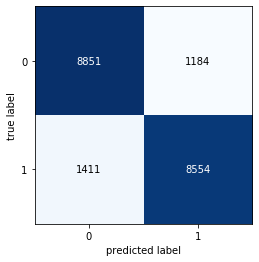

In [33]:
# choosing classifier
classifier = LogisticRegression(class_weight = "balanced", C=0.5, solver='sag')
model(df_sampled,classifier)

In [41]:
word_vectorizer = TfidfVectorizer(sublinear_tf=True,strip_accents='unicode',
        analyzer='word',token_pattern=r'\w{1,}',stop_words='english',
        ngram_range=(1, 1),max_features=10000)

word_vectorizer.fit(df_sampled['review_clean'])
    
# train - test vectorized features
word_features = word_vectorizer.transform(df_sampled['review_clean'])

scores = cross_val_score(classifier, word_features, df_sampled['sentiment'], cv=3, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

0.9279297166746745 +/- 0.007239511450023723


(80000,)
(20000,)
Accuracy:
TRAIN: 0.631475
TEST: 0.6291

Balanced Accuracy:
TRAIN: 0.63172354616334
TEST: 0.6281000442255418


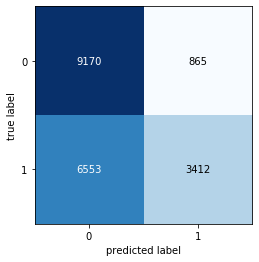

In [36]:
des_tree = DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_leaf=5, 
                                        random_state=42, class_weight='balanced')
model(df_sampled,des_tree)

(80000,)
(20000,)
Accuracy:
TRAIN: 0.7699
TEST: 0.7641

Balanced Accuracy:
TRAIN: 0.7698443487870796
TEST: 0.7643179628950455


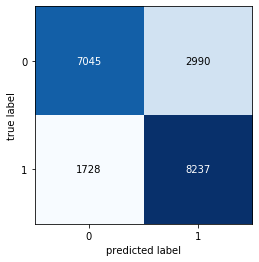

In [37]:
rf_extra = ExtraTreesClassifier(max_depth=5, criterion= 'entropy', min_samples_leaf=3, min_samples_split=18, 
                          random_state=42, n_estimators = 100, class_weight='balanced', n_jobs = -1)

model(df_sampled,rf_extra)

(80000,)
(20000,)
Accuracy:
TRAIN: 0.7699
TEST: 0.7641

Balanced Accuracy:
TRAIN: 0.7698443487870796
TEST: 0.7643179628950455


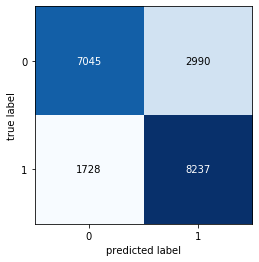

In [46]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1,class_weight='balanced',
                            criterion = 'entropy',max_features = 'sqrt',min_samples_split = 10)
model(df_sampled,rf_extra)

In [44]:
# grid_p = {"n_estimators": [20, 50, 100],
#           "criterion": ["gini", "entropy"],
#           "max_features": ['sqrt', 'log2'],
#           "min_samples_split": [2, 5, 10]}

# grid_search = GridSearchCV(rf, grid_p, n_jobs=-1, cv=3, scoring='roc_auc')
# grid_search.fit(word_features, df_sampled['sentiment'])

In [ ]:
# grid_search.best_score_

In [ ]:
# best_rf = grid_search.best_estimator_

(80000,)
(20000,)
Accuracy:
TRAIN: 0.884125
TEST: 0.83025

Balanced Accuracy:
TRAIN: 0.8841447081732923
TEST: 0.8301441442657672


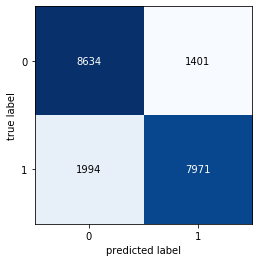

In [47]:
xgb = XGBClassifier(objective = 'multi:softmax', booster = 'gbtree', nrounds = 'min.error.idx',
                      num_class = 3, maximize = False, eval_metric = 'merror',early_stopping_rounds=10,
                        eta = .1,max_depth = 12, colsample_bytree = .4, learning_rate = 0.1,
                        max_delta_step=1)
model(df_sampled, xgb)

(80000,)
(20000,)
Accuracy:
TRAIN: 0.8344125
TEST: 0.8185

Balanced Accuracy:
TRAIN: 0.8344308904236505
TEST: 0.8184018754229739


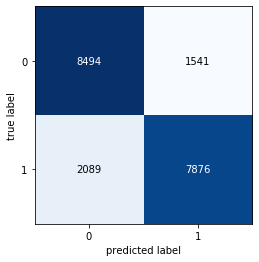

In [49]:
lgbm = LGBMClassifier(booster = 'gbtree', nrounds = 'min.error.idx', maximize = False,eta = .1,max_depth = 10, 
                      colsample_bytree = .4,learning_rate = 0.1,max_delta_step=1)
model(df_sampled, lgbm)